In [10]:
import os, gdown, shutil
from glob import glob

def data_yuklash(path, ds_name = "cells"):

    url = "https://drive.google.com/file/d/1WOXGltOXay7BsmwDxu8yKLw_hQIcQLf7/view?usp=sharing" if ds_name == "cars" else "https://drive.google.com/file/d/1c4oON03uBSxcGlluBFHTtkhFibUPSWs7/view?usp=share_link"

    if ds_name == "cells":

        # if os.path.isdir(path): shutil.rmtree(path)

        if os.path.isdir(f"{path}/{ds_name}"): print("Data yuklab olingan!"); pass

        else:
            print("Data yuklab olinmagan!")
            os.makedirs(path, exist_ok = True)
            # Url of the checkpoint

            # Get file id
            file_id = url.split("/")[-2]
            # Set prefix
            prefix = "https://drive.google.com/uc?/export=download&id="
            # Download the checkpoint
            gdown.download(prefix + file_id, path, quiet = False)
            folder_name = glob(f"{path}/*")[0]
            os.system(f"unzip {folder_name} -d {path}")
            os.remove(folder_name)

    elif ds_name == "cars":

        if os.path.isdir(f"{path}/{ds_name}"): print("Data yuklab olingan!"); pass

        else:
            print("Data yuklab olinmagan!")
            os.makedirs(path, exist_ok = True)
            # Url of the checkpoint

            # Get file id
            file_id = url.split("/")[-2] # 1c4oON03uBSxcGlluBFHTtkhFibUPSWs7; https://drive.google.com/uc?/export=download&id=1c4oON03uBSxcGlluBFHTtkhFibUPSWs7
            # Set prefix
            prefix = "https://drive.google.com/uc?/export=download&id="
            # Download the checkpoint
            gdown.download(prefix + file_id, path, quiet = False)
            folder_name = [file for file in glob(f"{path}/*") if "cells" not in file]
            fname = folder_name[0].split("/")[-1]
            os.system(f"unzip {path}/{fname} -d {path}")
            os.remove(f"{path}/{fname}")
            os.rename(f"{path}/CARS_DATA", f"{path}/{ds_name}")

path = "data"
data_yuklash(path = path, ds_name = "cars")

Data yuklab olinmagan!


Downloading...
From: https://drive.google.com/uc?/export=download&id=1WOXGltOXay7BsmwDxu8yKLw_hQIcQLf7
To: /content/data
100%|██████████| 54.1M/54.1M [00:01<00:00, 28.3MB/s]


In [11]:
import torch, os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from glob import glob
from PIL import Image

# 1) __init__; 2) __len__; 3) __getitem__;

class CustomDataset(Dataset):

    def __init__(self, data_yulagi, transformations = None):

        self.rasm_yulaklari = glob(f"{data_yulagi}/*/*.jpg")
        self.transformations = transformations

        # dictionary da kalitlarimiz class_nomlari va qiymatlarimiz raqam
        self.klass_nomlari = {}
        klass_qiymati = 0

        for idx, yulak in enumerate(self.rasm_yulaklari):
            # if idx == 1000: break
            klass_nomi = self.klassni_olib_kelish(yulak)
            if not klass_nomi in self.klass_nomlari: self.klass_nomlari[klass_nomi] = klass_qiymati; klass_qiymati += 1

    def __len__(self): return len(self.rasm_yulaklari)

    def klassni_olib_kelish(self, yulak): return os.path.dirname(yulak).split("/")[-1]

    def __getitem__(self, indeks):

    # ODDIY datasetdagi getitem dan qaytadigan o'zgaruvchilar soni 2ta: 1) rasm data turi -> tensor; 2) javob (gt, class, label) data turi -> int;
        rasm = Image.open(self.rasm_yulaklari[indeks])

        if self.transformations: rasm = self.transformations(rasm)

        javob = self.klass_nomlari[self.klassni_olib_kelish(self.rasm_yulaklari[indeks])]

        return rasm, javob

tfs = T.Compose([T.Resize((224, 224)), T.ToTensor()])
ds = CustomDataset(data_yulagi = "data/cars", transformations = tfs)
klass_nomlari = ds.klass_nomlari
# print(len(ds[10]))
# print(type(ds[10][0]))
# print(type(ds[10][1]))
print(klass_nomlari)
print(len(klass_nomlari))

{'nemo citroen': 0, 'Golf': 1, 'seat ibiza': 2, 'volkswagen tiguan': 3, 'picanto': 4, 'toyota corolla': 5, 'duster': 6, 'hyundai tucson': 7, 'logan': 8, 'chevrolet spark': 9, 'hyundai i10': 10, 'chevroulet aveo': 11, 'megane': 12, 'symbol': 13, 'bmw serie 1': 14, 'mercedes class a': 15, 'clio': 16, 'polo': 17, 'sandero': 18, 'octavia': 19}
20


In [12]:
split = [0.9, 0.05, 0.05]

all_len = len(ds)
tr_len = int(all_len * split[0])
val_len = int(all_len * split[1])
ts_len = all_len - tr_len - val_len
print(tr_len); print(val_len); print(ts_len)

2911
161
163


In [13]:
tr_ds, val_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, val_len, ts_len])
print(len(tr_ds), len(val_ds), len(ts_ds))

2911 161 163


In [14]:
batch_size = 128 # 64 * 2 = 128; 161 - 128 = 33
tr_dl = DataLoader(dataset = tr_ds, batch_size = batch_size, shuffle = True, num_workers = 2)
val_dl = DataLoader(dataset = val_ds, batch_size = batch_size, shuffle = False, num_workers = 2)
ts_dl = DataLoader(dataset = ts_ds, batch_size = batch_size, shuffle = False, num_workers = 2)
print(len(tr_dl), len(val_dl), len(ts_dl))

23 2 2


In [15]:
import torch
from torch import nn


class Model(nn.Module):



    def __init__(self, in_chs, out_chs,in_fs, ks,s, p, n_cls) :
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_chs, out_channels = out_chs, kernel_size=ks, stride= s, padding = p)
        self.conv_2 = nn.Conv2d(in_channels=out_chs, out_channels = out_chs*2, kernel_size=ks, stride= s, padding = p)
        self.conv_3 = nn.Conv2d(in_channels=out_chs*2, out_channels = out_chs*4, kernel_size=ks, stride= s, padding = p)

        self.linear_1 = nn.Linear(in_features=in_fs, out_features= in_fs // 2)
        self.linear_2 = nn.Linear(in_features=in_fs //2 , out_features= n_cls)
        self.act = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size =2, stride = 2)


    def forward(self, inp):

      out = self.conv_1(inp)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_2(out)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_3(out)
      out = self.act(out)
      out = self.mp(out)

      print(out.shape)

      bs= inp.shape[0]
      out = out.view(bs, -1)

      out= self.linear_1(out)
      out = self.act(out)
      out = self.linear_2(out)

      return out

rasm = torch.rand(1, 3, 224, 224)
model = Model(in_chs = 3, out_chs=8, in_fs= 25088 , ks=3 , s=1, p=1, n_cls=20)
model(rasm).shape

torch.Size([1, 32, 28, 28])


torch.Size([1, 20])

In [16]:
!pip install timm

import timm
model = timm.create_model(model_name = "resnet18", pretrained = True, num_classes = len(klass_nomlari))
# model = timm.create_model(model_name = "resnet18", pretrained = True)
model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [17]:
epochs = 2
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [18]:
from tqdm import tqdm
import os

best_acc = 0
prefix = "cars"

for epoch in range(epochs):
    model.train()
    print(f"{epoch + 1} - epoch jarayonlari boshlandi")

    epoch_loss, epoch_acc, total = 0, 0, 0

    for i, batch in tqdm(enumerate(tr_dl)):
        rasm, gts = batch
        rasm, gts = rasm.to(device), gts.to(device)
        total += rasm.shape[0]

        preds = model(rasm)
        loss = loss_fn(preds, gts)
        pred_cls = torch.argmax(preds.data, dim=1)
        epoch_acc += (pred_cls == gts).sum().item()
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1}- epoch train jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi train loss     -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi train accuracy     -> {(epoch_acc / total):.3f}")


    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0

        for ids, batch in tqdm(enumerate(val_dl)):
            rasm, gts = batch
            rasm, gts = rasm.to(device), gts.to(device)
            val_total += rasm.shape[0]

            preds = model(rasm)
            loss = loss_fn(preds, gts)
            pred_cls = torch.argmax(preds.data, dim=1)

            val_epoch_acc += (pred_cls == gts).sum().item()
            val_epoch_loss += loss.item()


        val_acc = val_epoch_acc / val_total

        print(f"\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
        print(f"{epoch + 1}- epoch validation jarayoni natijalari :")
        print(f" {epoch + 1}- epochdagi validation loss     -> {(val_epoch_loss / len(val_dl)):.3f}")
        print(f" {epoch + 1}- epochdagi validation accuracy     -> {(val_acc):.3f}")


        if val_acc > best_acc:
            os.makedirs("modellar", exist_ok=True)
            best_acc = val_acc
            torch.save(model.state_dict(), f"modellar/{prefix}_best_model.pth")


1 - epoch jarayonlari boshlandi


23it [15:45, 41.12s/it]


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1- epoch train jarayoni natijalari :
 1- epochdagi train loss     -> 2.575
 1- epochdagi train accuracy     -> 0.243



2it [00:17,  8.99s/it]


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1- epoch validation jarayoni natijalari :
 1- epochdagi validation loss     -> 1.942
 1- epochdagi validation accuracy     -> 0.460
2 - epoch jarayonlari boshlandi



23it [15:39, 40.83s/it]


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2- epoch train jarayoni natijalari :
 2- epochdagi train loss     -> 1.383
 2- epochdagi train accuracy     -> 0.666



2it [00:17,  9.00s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2- epoch validation jarayoni natijalari :
 2- epochdagi validation loss     -> 1.121
 2- epochdagi validation accuracy     -> 0.739


In [19]:
rasm, gts = next(iter(ts_dl))


model.eval ()
preds = []
images = []
lbls = []

for rasm, gt in zip(rasm, gts):
  rasm, gt = rasm.to(device), gt.to(device)
  pred = model(rasm.unsqueeze(0))
  pred_class = torch.argmax(pred, dim =1)
  images.append(rasm)
  lbls.append(gt)
  preds.append(pred_class)
print(len(preds))

128


In [20]:
import random

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = tfs.Compose([tfs.Normalize(mean = [ 0.], std = [1/0.5]), tfs.Normalize(mean = [-0.5], std = [1])])
    # rgb_tfs = tfs.Compose([tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    rgb_tfs = tfs.Compose([tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.5, 1/0.5, 1/0.5 ]), tfs.Normalize(mean = [ -0.5, -0.5, -0.5 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)


def visualize(data, rasmlar_soni, qatorlar, cmap = None, klass_nomlari = None):

    assert cmap in [ "gray"]
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if klass_nomlari is not None:
            plt.title (klass_nomlari[gt])
        else:
            plt.title(f"GT -> {gt}")

In [21]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("download.jpeg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


torch.Size([3, 224, 224])


In [22]:
import matplotlib.pyplot as plt
import numpy as np


'chevrolet spark'

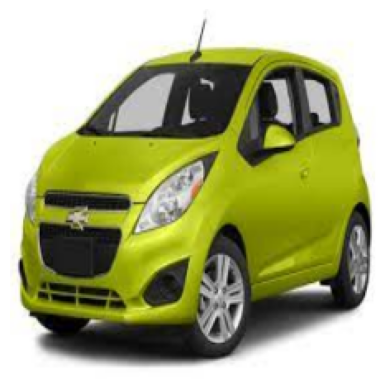

In [25]:
pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_nomlari.keys())[pred_class.item()]
# plt.title  (klass_nomlari[pred_class.item()])

In [26]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("1.webp")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


torch.Size([3, 224, 224])


'hyundai i10'

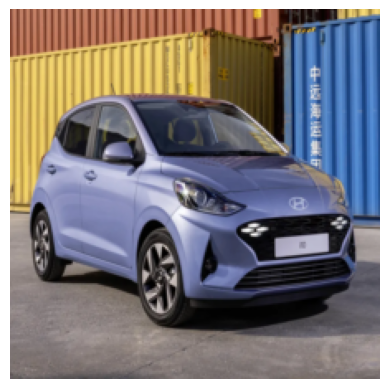

In [27]:
pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_nomlari.keys())[pred_class.item()]
# plt.title  (klass_nomlari[pred_class.item()])